In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Learning curve
from sklearn.model_selection import learning_curve

# algorithms
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

# Feature engineer 
from feature_engine.selection import DropFeatures
from feature_engine.encoding import RareLabelEncoder
from sklearn.preprocessing import OneHotEncoder
from feature_engine.imputation import (MeanMedianImputer, CategoricalImputer)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Model_Selection
from sklearn.model_selection import train_test_split, cross_val_score

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [5]:
def load_data():
    global df
    df = pd.read_csv("Dados/train.csv",index_col=0)
    global df_pred
    df_pred = pd.read_csv("Dados/test.csv",index_col=0)
    global x
    x = df.drop('Survived',axis=1)
    global y
    y = df.Survived
    global seed
    seed = 42
    
    global x_train, x_test, y_train, y_test
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state = 42)
    
    global num_var, cat_var, target
    num_var = ['Pclass','Age','SibSp','Parch','Fare','Cabin_Size']
    cat_var = ['Sex','Cabin_code','Embarked','Name_Title', 'Name_family']
    target = ['Survived']

In [6]:
load_data()

# Functions

In [7]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate plot: the test and training learning curve
    """
    if axes is None:
        _, axes = plt.subplots(1, figsize=(20, 10))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring='accuracy',
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")
    print('train_scores_mean: ',train_scores_mean[-1], '\ntest_scores_mean',test_scores_mean[-1])
    return plt

In [13]:
def get_cross_score(pipe,cv=5):
    score = cross_val_score(pipe, x_train, y_train, cv=cv, scoring='accuracy')
    print(f'accuracy of {np.round(score.mean(),4)} and standard deviation of {np.round(score.std(),4)}')

def make_sub(pipe,subname,save_to_drive=True):
    pipe.fit(x,y)
    pred = pipe.predict(df_pred)
    
    global last_sub
    last_sub = pd.DataFrame({'PassengerId': df_pred.index,
                             'Survived': pred})
    if save_to_drive:
        last_sub.to_csv('Predições/Experiments_nb/' +subname+'.csv',header=True, index=False)

# Feature Engineer

In [9]:
class get_feature_name(BaseEstimator, TransformerMixin):
    """create column with family name  and title of each passenger"""
    def __init__(self, title:bool=True,family:bool=True):
        self.title = title
        self.family = family
        pass
    
    def fit(self, x:pd.DataFrame, y:pd.Series=None):
        return self
    
    def transform(self, x:pd.DataFrame, y:pd.Series=None):
        df = x.copy()
        try:
            if self.title:
                df['Name_title'] = df['Name'].apply(lambda x: x.split(",")[1]).apply(lambda x: x.split(".")[0])
            
            if self.family:
                df['Name_family'] = df['Name'].apply(lambda x: x.split(",")[0])
            
        except:
            print('erro em get_name')
        return df
    
class dtype_fix(BaseEstimator,TransformerMixin):
    """ corrects dtype of all initial features"""
    
    def __init__(self, Pclass_type=True):
        self.Pclass_type=Pclass_type
        pass
    
    def fit(self, x:pd.DataFrame, y:pd.Series=None):
        return self
    
    def transform(self, x:pd.DataFrame,y:pd.Series=None):
        df=x.copy()
        try:
            if self.Pclass_type:
                df['Pclass']=df['Pclass'].astype('O')            
            df['Fare']=df['Fare'].astype('float')
            df['Sex']=df['Sex'].astype('object')
            df['Age']=df['Age'].astype('float')
            df['Cabin']=df['Cabin'].astype('object')
            df['Embarked']=df['Embarked'].astype('object')
        except:
            print('erro em dtype_fix')
        return df

class Mapper(BaseEstimator, TransformerMixin):
    """Create column with first character of the first Cabin and how many cabins"""
    
    def __init__(self,features:list=['Sex'],map_dicts=[{'male':1,'female':0}]):
        
        if not isinstance(map_dicts,list):
            raise ValueError('map_dicts should be a list of dictionarys')
            
        self.features = features
        self.map_dicts = map_dicts
        pass
    
    def fit(self, x:pd.DataFrame ,y:pd.Series=None):
        return self
    
    def transform(self,x:pd.DataFrame):
        x = x.copy()
        
        for i,feature in enumerate(self.features):
            x[feature] = x[feature].map(self.map_dicts[i])
        return x

class Cabin_code(BaseEstimator, TransformerMixin):
    """Create column with first character of the first Cabin and how many cabins"""
    
    def __init__(self,code=True,size=True):
        self.code=code
        self.size=size
        pass
        
    def fit(self, x:pd.DataFrame ,y:pd.Series=None):
        return self
    
    def transform(self,x:pd.DataFrame,y:pd.Series=None):
        x = x.copy()
        try:
            if self.code:
                x['Cabin_code'] = x['Cabin'].apply(lambda x: x[0])
            if self.size:
                x['Cabin_Size'] = x['Cabin'].apply(lambda x: len(x.split(" ")))
        except Exception as err:
            print('erro no Cabin_code')
            print(err)
        return x

In [11]:
#dict for enconding "Sex"
sex_map = {'male':1,
           'female':0}

# pipeline for imputing missing values
impute_pipe = Pipeline([
   ('Fix dtypes',dtype_fix(Pclass_type=True)),
   ('Cabin imputer',CategoricalImputer(variables=['Cabin'], fill_value='C')),
   ('Embarked imputer',CategoricalImputer(variables=['Embarked'], imputation_method='frequent')),
   ('Numeric imputer', MeanMedianImputer(variables=['Age','Fare'],imputation_method='median'))
                    ])

# pipeline for extracting features
ext_pp = make_pipeline(
    get_feature_name(family=True, title=True),
    Cabin_code(code=True,size=True)
                    )
# pipeline for categorical features processing
onehot_ct = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                     make_column_selector(dtype_include='object')),
                                   remainder='drop')
cat_pp = Pipeline([
    ('Binary encode Sex',Mapper(features=['Sex'],map_dict = sex_map)),
    ('OneHot', onehot_ct)
                ])

seed=42
#### MODELS
lr = LogisticRegression(random_state=seed)
rf = RandomForestClassifier(random_state=seed)
gbc = GradientBoostingClassifier(random_state=seed)
vt = VotingClassifier(voting='hard',estimators=[('lr', lr), ('rf', rf), ('gbc', gbc)])

# final pipeline
exp_pipe = Pipeline([
    ('Impute missing values',impute_pipe),
    ('Extract features',ext_pp), 
    ('Drop bad features',DropFeatures(features_to_drop=['Name','Cabin','Ticket'])), 
    ('Categorical Preprocess', cat_pp),
                      ])

final_pipe = make_pipeline(exp_pipe,
                         vt)
# cross validation
get_cross_score(final_pipe,cv=5)

x_1 =  exp_pipe.fit_transform(x)

accuracy of 0.8315 and standard deviation of 0.0413


train_scores_mean:  0.8365168539325843 
test_scores_mean 0.8126169104262132


<module 'matplotlib.pyplot' from 'C:\\Users\\ticom\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

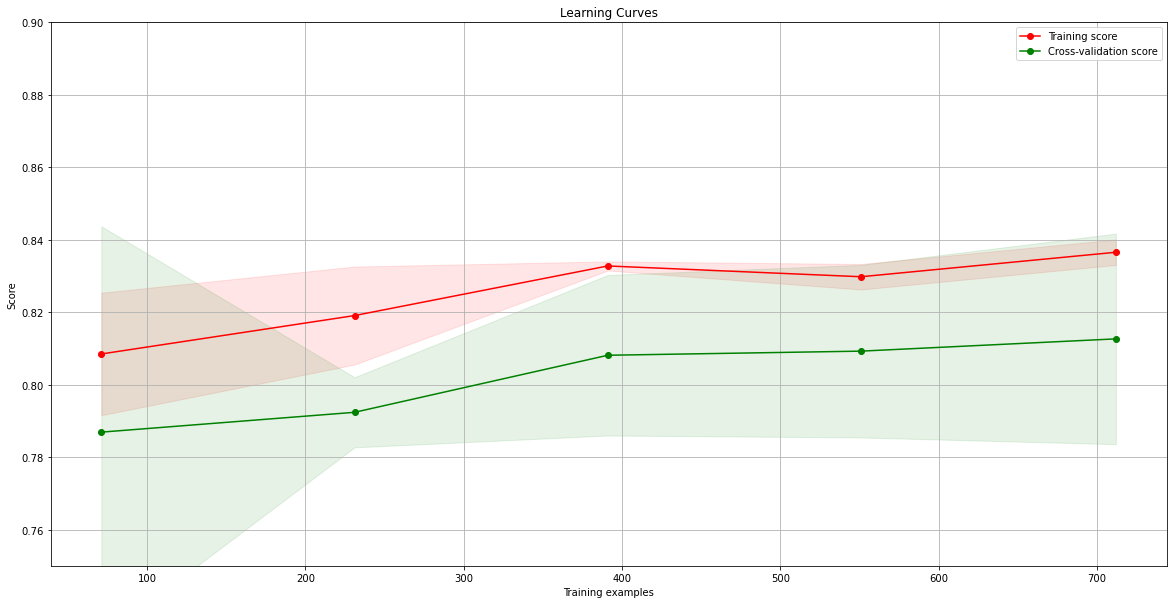

In [331]:
lgbm = LGBMClassifier(random_state=seed, n_estimators=100)

title = "Learning Curves"
plot_learning_curve(lgbm, title, x_1, y, ylim=(0.75, 0.9),
                    cv=5, n_jobs=-1)

Best Result so far: Acc = 0.80382 on the leaderboard

In [335]:
make_sub(final_pipe, 'best_score', save_to_drive=True)